In [8]:
from __future__ import print_function
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd

### 25 Neurons using concave down exponential function

test accuracy ~ 92-93%

Epoch 1: Train Accuracy: 66.18%, Test Accuracy: 85.92%
Epoch 2: Train Accuracy: 87.83%, Test Accuracy: 88.88%
Epoch 3: Train Accuracy: 89.23%, Test Accuracy: 89.40%
Epoch 4: Train Accuracy: 89.71%, Test Accuracy: 89.18%
Epoch 5: Train Accuracy: 90.35%, Test Accuracy: 90.76%
Epoch 6: Train Accuracy: 90.82%, Test Accuracy: 90.32%
Epoch 7: Train Accuracy: 91.02%, Test Accuracy: 88.29%
Epoch 8: Train Accuracy: 91.28%, Test Accuracy: 89.66%
Epoch 9: Train Accuracy: 91.49%, Test Accuracy: 90.49%
Epoch 10: Train Accuracy: 91.58%, Test Accuracy: 90.70%
Epoch 11: Train Accuracy: 91.68%, Test Accuracy: 91.51%
Epoch 12: Train Accuracy: 91.85%, Test Accuracy: 90.64%
Epoch 13: Train Accuracy: 91.94%, Test Accuracy: 91.89%
Epoch 14: Train Accuracy: 92.14%, Test Accuracy: 92.09%
Epoch 15: Train Accuracy: 92.28%, Test Accuracy: 92.52%
Epoch 16: Train Accuracy: 92.39%, Test Accuracy: 91.64%
Epoch 17: Train Accuracy: 92.50%, Test Accuracy: 92.10%
Epoch 18: Train Accuracy: 92.54%, Test Accuracy: 91.39%
E

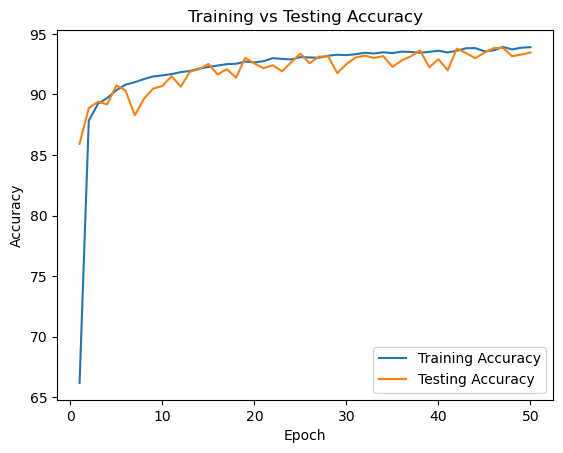

Final Weight Matrix (fc1):
tensor([[ 9.9979e-02,  9.7143e-02,  6.0590e-02,  ...,  2.9814e-01,
          1.3294e-01,  8.4253e-02],
        [ 1.0001e-01,  1.0046e-01,  7.9688e-02,  ...,  2.5668e-01,
          1.3605e-01,  8.1015e-02],
        [ 9.9996e-02,  9.7907e-02,  6.3414e-02,  ...,  6.7173e-01,
          5.6430e-02,  1.0069e-01],
        ...,
        [ 1.0000e-01,  9.8370e-02,  1.3184e-02,  ...,  4.2791e-05,
          1.9400e-02,  9.1382e-02],
        [ 9.9987e-02,  9.8918e-02,  9.2169e-02,  ...,  1.2103e-01,
          4.6671e-02,  1.0755e-01],
        [ 1.0003e-01,  1.0228e-01,  2.5486e-01,  ...,  1.3005e-02,
         -1.7200e-03,  1.2083e-01]])
Final Weight Matrix (fc2):
tensor([[-9.0898e-02,  7.0564e+00,  4.1767e+00, -5.5210e-03,  1.2640e+01,
         -1.3336e-02, -5.1131e+00, -2.3512e+00, -5.0021e-04,  6.0002e-02,
          1.1220e+01, -5.2950e-02, -1.1699e+00,  6.4701e+00,  9.1193e+00,
         -3.1221e+00, -2.3036e-01, -7.9102e+00,  5.9134e+00, -2.9897e+00,
          2.7832e+

In [9]:
# Provided parameter values
a = np.array([1.44459561, 1.4909716, 1.29900401, 1.59823275, 1.95377401,
              1.29692538, 1.3884494, 1.41366705, 1.4720679, 1.94549286,
              1.42256119, 1.35419586, 1.0655931, 1.4807465, 3.57915218,
              1.28707514, 1.29840168, 1.42614346, 2.301248, 1.82484445,
              1.37406175, 1.32049406, 1.48991211, 2.36839102, 2.57548982])
OD = np.array([10.62209668, 5.29927502, 5.24461367, 3.95714724, 3.53289089,
               4.90284341, 4.77882344, 4.21487304, 2.88143791, 3.68379522,
               7.11055405, 6.37264251, 5.52053175, 4.6822641, 3.91513311,
               3.79516812, 16.75179172, 4.82518489, 3.90599822, 4.43170833,
               4.68538009, 5.17359904, 5.77046094, 4.69307385, 4.32273257])
g = np.array([1018.98154797, 2459.73045748, 1571.1443399, 4717.39214842,
              7757.19215507, 1678.80384039, 2371.79623817, 2763.04246768,
              5398.06831678, 6639.08957198, 1498.46771748, 1437.98348092,
              896.57655106, 2596.58011685, 15084.55697028, 2336.91028423,
              456.33896778, 2464.47850684, 8199.06494407, 4530.89552788,
              2122.01729478, 1659.39463412, 2229.42490177, 6774.64313489,
              8393.47117689])

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Parameter(torch.full((25, 144), 0.1))
        self.fc2 = nn.Parameter(torch.rand(10, 25) / 200)
        #self.dropout = nn.Dropout(0.5)
        self.a_ = torch.tensor(a, dtype=torch.float32)
        self.OD = torch.tensor(OD, dtype=torch.float32)
        self.g = torch.tensor(g, dtype=torch.float32)

    def forward(self, x):
        x = x.view(-1, 144)
        x = F.linear(x, abs(self.fc1))
        #x = self.dropout(x)
        x = self.a_ * torch.exp(-self.OD * self.g / (x * 12800 + self.g))
        #x = self.dropout(x)
        out = F.linear(x, abs(self.fc2))
        return out

def train(model, device, train_loader, optimizer):
    model.train()
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

def val(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, val_accuracy

def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(12),
                           transforms.ToTensor(),
                        ]))
    train_size = int(0.75 * len(dataset1))
    val_size = int(0.10 * len(dataset1))
    test_size = len(dataset1) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset1, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    epochs = 50
    train_accuracies = []
    test_accuracies = []
    for epoch in range(1, epochs + 1):
        train_accuracy = train(model, device, train_loader, optimizer)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f'Epoch {epoch}: Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    # Plotting the training and testing accuracies
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Testing Accuracy')
    plt.legend()
    plt.show()

    print("Final Weight Matrix (fc1):")
    print(model.fc1.data)
    print("Final Weight Matrix (fc2):")
    print(model.fc2.data)   

if __name__ == '__main__':
    main()

### 25 Neurons using concave down exponential fucntion and fixed W1 matrix

Accuracy plattued at ~ 20-21%

/var/folders/5c/wxkzc1014j39gxn5lgfcb6480000gp/T/ipykernel_18161/1311322288.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.fc1 = torch.tensor(torch.full((25, 144), 0.01))  # Initialize with a uniform distribution of 0.1


Epoch 1: Train Accuracy: 10.94%, Test Accuracy: 14.90%
Epoch 2: Train Accuracy: 15.62%, Test Accuracy: 15.74%
Epoch 3: Train Accuracy: 18.21%, Test Accuracy: 19.38%
Epoch 4: Train Accuracy: 20.90%, Test Accuracy: 21.43%
Epoch 5: Train Accuracy: 21.97%, Test Accuracy: 21.72%
Epoch 6: Train Accuracy: 22.48%, Test Accuracy: 22.81%
Epoch 7: Train Accuracy: 22.53%, Test Accuracy: 22.14%
Epoch 8: Train Accuracy: 22.82%, Test Accuracy: 22.02%
Epoch 9: Train Accuracy: 22.54%, Test Accuracy: 22.57%
Epoch 10: Train Accuracy: 22.60%, Test Accuracy: 22.42%
Epoch 11: Train Accuracy: 22.47%, Test Accuracy: 22.60%
Epoch 12: Train Accuracy: 22.54%, Test Accuracy: 21.87%
Epoch 13: Train Accuracy: 22.45%, Test Accuracy: 22.57%
Epoch 14: Train Accuracy: 22.62%, Test Accuracy: 22.01%
Epoch 15: Train Accuracy: 22.67%, Test Accuracy: 22.38%
Epoch 16: Train Accuracy: 22.46%, Test Accuracy: 22.18%
Epoch 17: Train Accuracy: 22.55%, Test Accuracy: 21.72%
Epoch 18: Train Accuracy: 22.53%, Test Accuracy: 22.49%
E

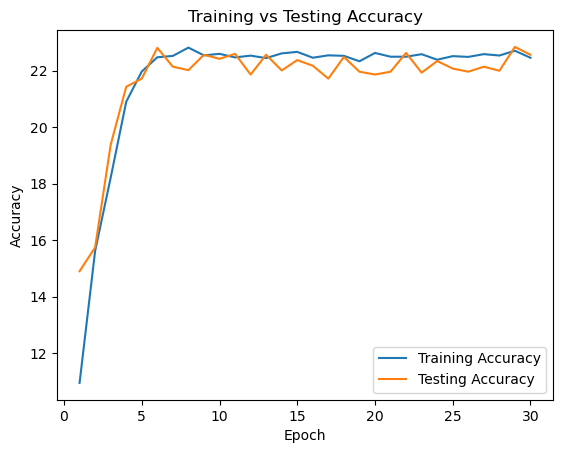

Final Weight Matrix (fc1):
tensor([[0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100],
        ...,
        [0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100]])
Final Weight Matrix (fc2):
tensor([[ 1.1839e+01,  4.2117e+00,  4.2023e+00, -5.0002e-02, -4.1962e-02,
          2.5278e+00,  2.2946e+00, -3.1635e-01,  5.9915e-02,  6.3759e-02,
          9.2979e+00,  8.2693e+00, -1.3581e+00,  1.7902e+00,  4.9906e-02,
         -1.3097e-01,  1.6693e+01,  2.4824e+00, -5.9360e-02,  6.2529e-02,
          1.8694e+00,  4.0494e+00,  5.6796e+00, -3.2886e-02, -3.7678e-02],
        [-6.3369e-04,  2.3077e-03, -3.8665e-03,  2.3834e-03, -9.3049e+00,
          7.4246e-05, -7.7294e-04, -1.5566e-02,  1.4246e+01,  4.5056e+00,
         -2.9612e-04,  1.2936

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

# Provided parameter values
a = np.array([1.44459561, 1.4909716, 1.29900401, 1.59823275, 1.95377401,
              1.29692538, 1.3884494, 1.41366705, 1.4720679, 1.94549286,
              1.42256119, 1.35419586, 1.0655931, 1.4807465, 3.57915218,
              1.28707514, 1.29840168, 1.42614346, 2.301248, 1.82484445,
              1.37406175, 1.32049406, 1.48991211, 2.36839102, 2.57548982])
OD = np.array([10.62209668, 5.29927502, 5.24461367, 3.95714724, 3.53289089,
               4.90284341, 4.77882344, 4.21487304, 2.88143791, 3.68379522,
               7.11055405, 6.37264251, 5.52053175, 4.6822641, 3.91513311,
               3.79516812, 16.75179172, 4.82518489, 3.90599822, 4.43170833,
               4.68538009, 5.17359904, 5.77046094, 4.69307385, 4.32273257])
g = np.array([1018.98154797, 2459.73045748, 1571.1443399, 4717.39214842,
              7757.19215507, 1678.80384039, 2371.79623817, 2763.04246768,
              5398.06831678, 6639.08957198, 1498.46771748, 1437.98348092,
              896.57655106, 2596.58011685, 15084.55697028, 2336.91028423,
              456.33896778, 2464.47850684, 8199.06494407, 4530.89552788,
              2122.01729478, 1659.39463412, 2229.42490177, 6774.64313489,
              8393.47117689])

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Fix the value of the first linear layer with a uniform distribution
        self.fc1 = torch.tensor(torch.full((25, 144), 0.01))  # Initialize with a uniform distribution of 0.1
        self.fc2 = nn.Parameter(torch.rand(10, 25) / 200)
        #self.dropout = nn.Dropout(0.5)
        self.a_ = torch.tensor(a, dtype=torch.float32)
        self.OD = torch.tensor(OD, dtype=torch.float32)
        self.g = torch.tensor(g, dtype=torch.float32)

    def forward(self, x):
        x = x.view(-1, 144)
        x = F.linear(x, abs(self.fc1))
        #x = self.dropout(x)
        x = self.a_ * torch.exp(-self.OD * self.g / (x * 12800 + self.g))
        #x = self.dropout(x)
        out = F.linear(x, abs(self.fc2))
        return out

def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(12),
                           transforms.ToTensor(),
                        ]))
    train_size = int(0.75 * len(dataset1))
    val_size = int(0.10 * len(dataset1))
    test_size = len(dataset1) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset1, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    epochs = 30
    train_accuracies = []
    test_accuracies = []
    for epoch in range(1, epochs + 1):
        train_accuracy = train(model, device, train_loader, optimizer)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f'Epoch {epoch}: Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    # Plotting the training and testing accuracies
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Testing Accuracy')
    plt.legend()
    plt.show()

    print("Final Weight Matrix (fc1):")
    print(model.fc1.data)
    print("Final Weight Matrix (fc2):")
    print(model.fc2.data)

if __name__ == '__main__':
    main()


### 25 Neurons using concave up exponential function

In [36]:
# given curve fitted coefficients from experimental data
# the non-linear function is of the form a*np.exp(b*x) + c
# read the coefficients from the csv file with the given file path
file_path = '/Users/MacPro2021/Desktop/Quantum Game Club/AONN-1/NN/Optimized_Curve_Fitting_Parameters.csv'
# skip the first row of the csv file
list = pd.read_csv(file_path)

a = list.iloc[:, 1].to_numpy()
b = list.iloc[:, 2].to_numpy()
c = list.iloc[:, 3].to_numpy()

a = np.array(a)
b = np.array(b)
c = np.array(c)

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Parameter(torch.rand(25, 144) / 40000)
        self.fc2 = nn.Parameter(torch.rand(10, 25) / 200)
        # defining the new parameters from the csv file loaded in the cell above
        self.a = torch.tensor(a, dtype=torch.float32)
        self.b = torch.tensor(b, dtype=torch.float32)
        self.c = torch.tensor(c, dtype=torch.float32)

    def forward(self, x):
        x = x.view(-1, 144)
        x = F.linear(x, abs(self.fc1))
        #x = self.dropout(x)
        x = self.a * torch.exp(self.b * x) + self.c
        #x = self.dropout(x)
        out = F.linear(x, abs(self.fc2))
        return out

def train(model, device, train_loader, optimizer):
    model.train()
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

def val(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, val_accuracy

def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(12),
                           transforms.ToTensor(),
                        ]))
    train_size = int(0.75 * len(dataset1))
    val_size = int(0.10 * len(dataset1))
    test_size = len(dataset1) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset1, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    epochs = 30
    train_accuracies = []
    test_accuracies = []
    for epoch in range(1, epochs + 1):
        train_accuracy = train(model, device, train_loader, optimizer)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f'Epoch {epoch}: Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    # Plotting the training and testing accuracies
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Testing Accuracy')
    plt.legend()
    plt.show()

    print("Final Weight Matrix (fc1):")
    print(model.fc1.data)
    print("Final Weight Matrix (fc2):")
    print(model.fc2.data)   

if __name__ == '__main__':
    main()

TypeError: unsupported operand type(s) for +: 'Tensor' and 'Net'